In [ ]:
!git clone https://github.com/110805/CGAN.git
%cd CGAN/

Cloning into 'CGAN'...
remote: Enumerating objects: 18029, done.
remote: Total 18029 (delta 0), reused 0 (delta 0), pack-reused 18029
Receiving objects: 100% (18029/18029), 1.88 GiB | 15.94 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (18021/18021), done.
/content/CGAN


In [ ]:
import PIL.Image as Image
import json
from torch.utils import data
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
import torchvision
import matplotlib.pyplot as plt

In [ ]:
class iclevrDataSet(data.Dataset):
    def __init__(self):
        with open('/content/CGAN/dataset/train.json', 'r') as f:
            file_dict = json.load(f)

        self.length = len(file_dict)
        self.img_name = list(file_dict.keys())
        self.labels = list(file_dict.values())
        self.transformations = transforms.Compose([transforms.Resize((64, 64)),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                   ])

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        img_path = '/content/CGAN/iclevr/' + self.img_name[index]
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = self.transformations(img)

        labels = self.labels[index]
        label = []
        with open('/content/CGAN/dataset/objects.json', 'r') as f:
            obj_dict = json.load(f)

        for i in labels:
            label.append(obj_dict[i])

        labels = torch.zeros(24)
        for i in label:
            labels[i] = 1.0

        return img, labels

In [ ]:
class evaluation_model():
    def __init__(self):
        #modify the path to your own path
        checkpoint = torch.load('classifier_weight.pth')
        self.resnet18 = models.resnet18(pretrained=False)
        self.resnet18.fc = nn.Sequential(
            nn.Linear(512,24),
            nn.Sigmoid()
        )
        self.resnet18.load_state_dict(checkpoint['model'])
        self.resnet18 = self.resnet18.cuda()
        self.resnet18.eval()
        self.classnum = 24
    def compute_acc(self, out, onehot_labels):
        batch_size = out.size(0)
        acc = 0
        total = 0
        for i in range(batch_size):
            k = int(onehot_labels[i].sum().item())
            total += k
            outv, outi = out[i].topk(k)
            lv, li = onehot_labels[i].topk(k)
            for j in outi:
                if j in li:
                    acc += 1
        return acc / total
    def eval(self, images, labels):
        with torch.no_grad():
            #your image shape should be (batch, 3, 64, 64)
            out = self.resnet18(images)
            acc = self.compute_acc(out.cpu(), labels.cpu())
            return acc

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    def __init__(self, in_dim, dim=64):
        super(Generator, self).__init__()
        self.label_embed = nn.Linear(24, in_dim)
        def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, 5, 2,
                                   padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU())

        self.l1 = nn.Sequential(
            nn.Linear(in_dim, dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 8 * 4 * 4),
            nn.ReLU())

        self.l2_5 = nn.Sequential(
            dconv_bn_relu(dim * 8, dim * 4),
            dconv_bn_relu(dim * 4, dim * 2),
            dconv_bn_relu(dim * 2, dim),
            nn.ConvTranspose2d(dim, 3, 5, 2, padding=2, output_padding=1),
            nn.Tanh())

        self.apply(weights_init)

    def forward(self, z, c):
        y = self.label_embed(c)
        y = torch.mul(y, z)
        y = self.l1(y)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y

class Discriminator(nn.Module):
    def __init__(self, in_dim, dim=64):
        super(Discriminator, self).__init__()
        self.label_embed = nn.Linear(24, dim*dim)
        def conv_bn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2),
                )

        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, 5, 2, 2), nn.LeakyReLU(0.2),
            conv_bn_lrelu(dim, dim * 2),
            conv_bn_lrelu(dim * 2, dim * 4),
            conv_bn_lrelu(dim * 4, dim * 8),
            nn.Conv2d(dim * 8, 1, 4),
            )

        self.apply(weights_init)

    def forward(self, x, c):
        y = self.label_embed(c)
        y = y.view(-1, 1, 64, 64)
        y = torch.cat((y, x), dim=1)
        y = self.ls(y)
        y = y.view(-1)
        return y

'''
z = torch.randn(4, 128)
c = torch.randn(4, 24)
img = torch.randn(4, 3, 64, 64)
G = Generator(128)
y = G.forward(z, c)
D = Discriminator(4)
y = D.forward(img, c)
'''

'\nz = torch.randn(4, 128)\nc = torch.randn(4, 24)\nimg = torch.randn(4, 3, 64, 64)\nG = Generator(128)\ny = G.forward(z, c)\nD = Discriminator(4)\ny = D.forward(img, c)\n'

In [ ]:
# hyperparameters
batch_size = 64
z_dim = 128
lr = 1e-4
n_epoch = 100

# model
G = Generator(z_dim).cuda()
D = Discriminator(4).cuda()

# loss criterion
criterion = nn.BCELoss()

# optimizer
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

# dataset
dataset = iclevrDataSet()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# test conditions
with open('/content/CGAN/dataset/objects.json', 'r') as file:
    obj_dict = json.load(file)

with open('/content/CGAN/dataset/new_test.json','r') as file:
    test_dict = json.load(file)
    n_test = len(test_dict)

test_c = torch.zeros(n_test, 24)
for i in range(n_test):
    for condition in test_dict[i]:
        test_c[i, obj_dict[condition]] = 1.

In [ ]:
best_score = 0
test_z = torch.randn(n_test, z_dim)
test_c = test_c.cuda()
test_z = test_z.cuda()
eval_model = evaluation_model()
for epoch in range(n_epoch):
    G.train()
    D.train()
    for i, (imgs, c) in enumerate(dataloader):
        imgs = imgs.cuda()
        c = c.cuda()
        bs = imgs.size(0) # batch size

        # label
        real_label = torch.ones(bs)
        fake_label = torch.zeros(bs)
        '''
        # label smoothing
        real_label = real_label - 0.3 + 0.5*torch.rand(bs) # smoothing the label values uniformly into the range [0.7,1.2]
        fake_label = fake_label + 0.3*torch.rand(bs) # smoothing the label values uniformly into the range [0.0,0.3]

        # noisy label with 5% to change the labels
        e = torch.randn(bs)
        for j in range(bs):
            if e[j]>2 or e[j]<-2:
                temp = real_label[j]
                real_label[j] = fake_label[j]
                fake_label[j] = temp
        '''
        real_label = real_label.cuda()
        fake_label = fake_label.cuda()
        """ Train Discriminator """
        if (i+1)%6==0 or i==0:
            opt_D.zero_grad()
            z = torch.randn(bs, z_dim).cuda()
            fake_imgs = G(z, c)

            # discriminator
            real_logit = D(imgs.detach(), c)
            fake_logit = D(fake_imgs.detach(), c)

            # compute loss
            real_loss = criterion(real_logit, real_label)
            fake_loss = criterion(fake_logit, fake_label)
            loss_D = (real_loss + fake_loss) / 2

            # update model
            loss_D.backward()
            opt_D.step()

        """ train Generator """

        opt_G.zero_grad()
        z = torch.randn(bs, z_dim).cuda()
        fake_imgs = G(z, c)

        # discriminator
        fake_logit = D(fake_imgs, c)

        # compute loss
        loss_G = criterion(fake_logit, real_label)

        # update model
        loss_G.backward()
        opt_G.step()

        # log
        print(f'\rEpoch [{epoch+1}/{n_epoch}] {i+1}/{len(dataloader)} Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}', end='')

    G.eval()
    with torch.no_grad():
        gen_imgs = G(test_z, test_c)

    score = eval_model.eval(gen_imgs, test_c)
    print(f'\nScore: {score:.2f}')
    if score > best_score:
        torch.save(G.state_dict(), 'g100_weight.pth')
        torch.save(D.state_dict(), 'd100_weight.pth')
        torchvision.utils.save_image(gen_imgs, 'result.png', nrow=8, normalize=True)
        best_score = score

    # show generated image
    grid_img = torchvision.utils.make_grid(gen_imgs.cpu(), nrow=8, normalize=True)
    plt.figure(figsize=(8, 4))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()


Score: 0.52


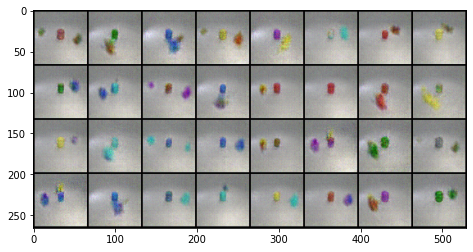

In [ ]:
#test_z = torch.randn(32, z_dim)
test_z = torch.load('new_test_z.pt')
test_c = test_c.cuda()
test_z = test_z.cuda()
eval_model = evaluation_model()

G = Generator(z_dim).cuda()
G.load_state_dict(torch.load('g100_weight.pth'))

with torch.no_grad():
    gen_imgs = G(test_z, test_c)

    score = eval_model.eval(gen_imgs, test_c)
    print(f'\nScore: {score:.2f}')

# show generated image
    grid_img = torchvision.utils.make_grid(gen_imgs.cpu(), nrow=8, normalize=True)
    plt.figure(figsize=(8, 4))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()